# Scholarship Budget

## Data download

In [ ]:
data_download = 'https://raw.githubusercontent.com/AEBU/mlzoomcamp/main/capstone-project/senescyt_becas_2022febrero.zip'
data_output_zip = 'scolarships_ec.zip'
filename = 'senescyt_becas_2022febrero.csv'

!wget $data_download -O $data_output_zip
!unzip $data_output_zip

In [23]:
!head $filename

;8;9;10;11;12;13;14;;30;31;5239,51;436,6258333;35;36;23;24;25;26;28;29;60;ESCUELA SUPERIOR POLITECNICA DE CHIMBORAZOCAMPUS MORONA SANTIAGO ;68;62;63;172;64;65;66;78;83;84;184;190;191;203;182;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
ID UNICO;ETNIA;GENERO;DISCAPACIDAD;TIPO DISCAPACIDAD;PORCENTAJE DISCAPACIDAD;ESTADO CIVIL;FECHA DE NACIMIENTO;PROVINCIA NACIMIENTO HOMOLOGADA;PROVINCIA NACIMIENTO;CANTON NACIMIENTO;ZONA SENPLADES LUGAR NACIMIENTO;PROVINCIA RESIDENCIA HOMOLOGADA;PROVINCIA RESIDENCIA;CANTON RESIDENCIA;PROGRAMA GENERAL;SUBPROGRAMA;CONVOCATORIA;COMPONENTE;DESTINO;FINANCIAMIENTO;CENTRO ESTUDIOS BECA;IES DE ESTUDIOS HOMOLOGADA;PAIS DE ESTUDIOS;NIVEL DE ESTUDIOS ;NIVEL DETALLADO;CARRERA ;AREA DE ESTUDIO ;SUBAREA DE ESTUDIO ;AREA ESTUDIO DETALLADO ;FECHA DE SUSCRIPCION;FECHA INICIO FINANCIAMIENTO;FECHA FIN FINANCIAMIENTO;MONTO CONTRATADO;FECHA INICIO ESTUDIOS;FECHA FIN ESTUDIOS;ESTADO ESTUDIANTE;ESTADO BECA;;;;;;;;;;;;;

## Importing libraries

In [71]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.tree import export_text
from sklearn.metrics import mutual_info_score

from datetime import datetime
from datetime import date
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge


from IPython.display import display

%matplotlib inline

### Define functions

In [70]:
def calculate_age(date_age, type_calculate = 1):
    try: 
        if type_calculate == 1:
            birth_day = pd.to_datetime(date_age, format='%d/%m/%Y')
            today = date.today()
            return today.year - birth_day.year - ((today.month, today.day) < (birth_day.month, birth_day.day))
        elif type_calculate == 2:
            return pd.to_datetime(date_age, format='%d/%m/%Y')
    except Exception as e:
        print(e)
        return np.nan


def change_replace(str_replace, str_input_replace, str_out_replace):
    try: 
        return str_replace.replace(str_input_replace,str_out_replace )
    except Exception as e:
        return str_replace
        
def mutual_info_amount_score(series):
    return mutual_info_score(series, df_full_train.monto_contratado)        

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)    
    

## Data Preparation

In [25]:
df_scolaships = pd.read_csv(filename, encoding='latin-1', sep=';', skiprows=1, dtype=str)
df_scolaships.head()

,ID UNICO,ETNIA,GENERO,DISCAPACIDAD,TIPO DISCAPACIDAD,PORCENTAJE DISCAPACIDAD,ESTADO CIVIL,FECHA DE NACIMIENTO,PROVINCIA NACIMIENTO HOMOLOGADA,PROVINCIA NACIMIENTO,...,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142
0,1111111083,AFRODESCENDIENTE,MASCULINO,NO,-,-,SOLTERO(A),02/11/1982,PICHINCHA,PICHINCHA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1111122538,MESTIZO,FEMENINO,NO,-,-,SOLTERO(A),01/03/1987,EXTERIOR,EXTERIOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1111134392,MESTIZO,FEMENINO,NO,-,-,SOLTERO(A),02/03/1991,LOJA,LOJA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1111144329,MESTIZO,FEMENINO,NO,-,-,SOLTERO(A),16/06/1991,LOJA,LOJA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1111154365,MESTIZO,MASCULINO,NO,-,-,SOLTERO(A),27/03/1990,LOJA,LOJA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#@ FILTER ONLY NECCESARY FEATURES
df_scolaships = df_scolaships.iloc[: , 0:38].dropna(subset=['ID UNICO','ETNIA','GENERO'])
df_scolaships.head().T

In [31]:
#@ Variable standardization
df_scolaships.columns = df_scolaships.columns.str.lower().str.strip().str.replace(' ', '_')
string_columns = list(df_scolaships.dtypes[df_scolaships.dtypes == 'object'].index)

for col in string_columns:
    # df_scolaships[col] = df_scolaships[col].str.lower().str.replace(' ', '_')
    df_scolaships[col] = df_scolaships[col].str.lower().str.strip()\
                        .replace('no registrado', np.nan)\
                        .replace('%', '')\
                        .replace('-', None)

In [28]:
df_scolaships.columns

Index(['id_unico', 'etnia', 'genero', 'discapacidad', 'tipo_discapacidad',
       'porcentaje_discapacidad', 'estado_civil', 'fecha_de_nacimiento',
       'provincia_nacimiento_homologada', 'provincia_nacimiento',
       'canton_nacimiento', 'zona_senplades_lugar_nacimiento',
       'provincia_residencia_homologada', 'provincia_residencia',
       'canton_residencia', 'programa_general', 'subprograma', 'convocatoria',
       'componente', 'destino', 'financiamiento', 'centro_estudios_beca',
       'ies_de_estudios_homologada', 'pais_de_estudios', 'nivel_de_estudios',
       'nivel_detallado', 'carrera', 'area_de_estudio', 'subarea_de_estudio',
       'area_estudio_detallado', 'fecha_de_suscripcion',
       'fecha_inicio_financiamiento', 'fecha_fin_financiamiento',
       'monto_contratado', 'fecha_inicio_estudios', 'fecha_fin_estudios',
       'estado_estudiante', 'estado_beca'],
      dtype='object')

In [29]:
df_scolaships.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42116 entries, 0 to 42115
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id_unico                         42116 non-null  object
 1   etnia                            42048 non-null  object
 2   genero                           42116 non-null  object
 3   discapacidad                     42011 non-null  object
 4   tipo_discapacidad                25993 non-null  object
 5   porcentaje_discapacidad          25992 non-null  object
 6   estado_civil                     42015 non-null  object
 7   fecha_de_nacimiento              42020 non-null  object
 8   provincia_nacimiento_homologada  42115 non-null  object
 9   provincia_nacimiento             42116 non-null  object
 10  canton_nacimiento                42116 non-null  object
 11  zona_senplades_lugar_nacimiento  42107 non-null  object
 12  provincia_residencia_homologada 

In [30]:
df_scolaships.isnull().sum()

id_unico                               0
etnia                                 68
genero                                 0
discapacidad                         105
tipo_discapacidad                  16123
porcentaje_discapacidad            16124
estado_civil                         101
fecha_de_nacimiento                   96
provincia_nacimiento_homologada        1
provincia_nacimiento                   0
canton_nacimiento                      0
zona_senplades_lugar_nacimiento        9
provincia_residencia_homologada        0
provincia_residencia                   0
canton_residencia                      0
programa_general                       0
subprograma                            0
convocatoria                           0
componente                             0
destino                                0
financiamiento                         0
centro_estudios_beca                   0
ies_de_estudios_homologada             0
pais_de_estudios                       0
nivel_de_estudio

## Data Cleaning - Missing data

In [32]:
len(df_scolaships)

42116

In [33]:
df_scolaships.dropna(subset=['monto_contratado'], inplace=True)
len(df_scolaships)

42023

In [54]:
df_scolaships['tipo_discapacidad'] = df_scolaships['tipo_discapacidad'].replace('-', 'ninguna').replace('0', 'ninguna').fillna('ninguna')
df_scolaships['porcentaje_discapacidad'] = df_scolaships['porcentaje_discapacidad'].str.replace('%', '').str.replace('-', '0').fillna('0')
df_scolaships['etnia'] = df_scolaships['etnia'].fillna('no_definida')
df_scolaships['discapacidad'] = df_scolaships['discapacidad'].fillna('no')
df_scolaships['provincia_nacimiento_homologada'] = df_scolaships['provincia_nacimiento_homologada'].fillna('pichincha') # Se reemplaza con la moda

## Change variables types

In [36]:
df_scolaships['age'] = df_scolaships.fecha_de_nacimiento.apply(lambda x: calculate_age(x))
df_scolaships['fecha_inicio_estudios_rec'] =  pd.to_datetime(df_scolaships['fecha_inicio_financiamiento'], format='%d/%m/%Y') 
df_scolaships['anio_inicio_estudios'] =  pd.DatetimeIndex(df_scolaships['fecha_inicio_estudios_rec']).year
df_scolaships['age'] = df_scolaships.age.astype('float32')

In [37]:
# df_scolaships.age = df_scolaships.fecha_de_nacimiento.apply(lambda x: calculate_age(x))
# df_scolaships['age'] = pd.to_datetime(df_scolaships['fecha_de_nacimiento'], format='%d/%m/%Y')
df_scolaships.monto_contratado =df_scolaships.monto_contratado.apply(lambda x: change_replace(x,'.',''))
df_scolaships.monto_contratado = df_scolaships.monto_contratado.astype('float32')

In [38]:
df_estudios = df_scolaships[['fecha_inicio_estudios_rec','id_unico']].groupby('fecha_inicio_estudios_rec').count().reset_index()
fig = px.line(df_estudios, x='fecha_inicio_estudios_rec', y="id_unico")
fig.show()

In [39]:
df_estudios = df_scolaships[['anio_inicio_estudios','id_unico']].groupby('anio_inicio_estudios').count().reset_index()
fig = px.line(df_estudios, x='anio_inicio_estudios', y="id_unico")
fig.show()

In [40]:
minimum_year_filter = 2014

In [42]:
#@ Filter only data greater than minimum year
df_scolaships = df_scolaships[df_scolaships.fecha_inicio_estudios_rec.dt.year > minimum_year_filter]

In [43]:
df_scolaships.isnull().sum()

id_unico                              0
etnia                                39
genero                                0
discapacidad                          1
tipo_discapacidad                  7361
porcentaje_discapacidad            7362
estado_civil                          0
fecha_de_nacimiento                   0
provincia_nacimiento_homologada       1
provincia_nacimiento                  0
canton_nacimiento                     0
zona_senplades_lugar_nacimiento       9
provincia_residencia_homologada       0
provincia_residencia                  0
canton_residencia                     0
programa_general                      0
subprograma                           0
convocatoria                          0
componente                            0
destino                               0
financiamiento                        0
centro_estudios_beca                  0
ies_de_estudios_homologada            0
pais_de_estudios                      0
nivel_de_estudios                     0


In [44]:
df_scolaships.monto_contratado.value_counts().head(10)

81468.0    349
52424.0    154
2000.0     124
9920.0     103
1000.0      94
43724.0     88
19650.0     83
577.0       73
17062.0     73
3000.0      66
Name: monto_contratado, dtype: int64

## Analysis Target Variable

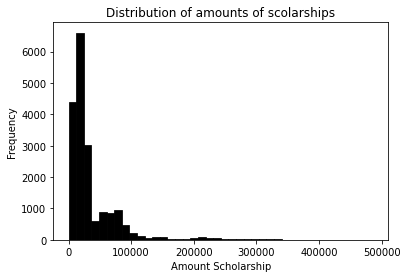

In [49]:
plt.figure(figsize=(6, 4))

sns.histplot(df_scolaships.monto_contratado, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Amount Scholarship')
plt.title('Distribution of amounts of scolarships')

plt.show()

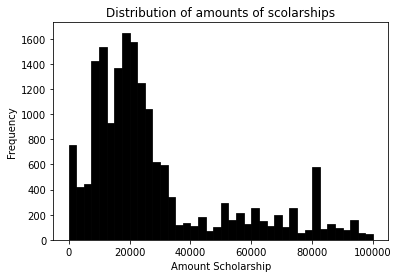

In [50]:
plt.figure(figsize=(6, 4))

sns.histplot(df_scolaships.monto_contratado[df_scolaships.monto_contratado < 100000], bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Amount Scholarship')
plt.title('Distribution of amounts of scolarships')

plt.show()

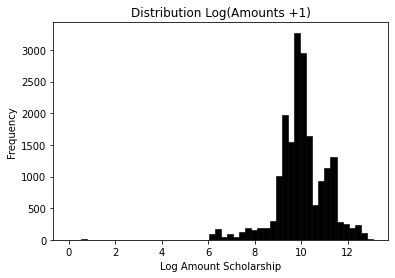

In [51]:
log_price = np.log1p(df_scolaships.monto_contratado)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=50, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log Amount Scholarship')
plt.title('Distribution Log(Amounts +1)')
plt.show()

## EDA

### Features Analysis

In [52]:
#@ Predominant age to scholarships
df_scolaships.age.value_counts().head(10)

25.0    1833
23.0    1807
26.0    1727
24.0    1713
22.0    1220
27.0    1140
28.0     812
32.0     771
34.0     765
33.0     756
Name: age, dtype: int64

In [56]:
#@ Analyze columns scholarships
for col in df_scolaships.columns :
    display(col,  df_scolaships[col].value_counts().head())
    # display(col,  df_scolaships[col].unique())
    # df_group = df_scolaships.groupby(by=col).monto_contratado.agg(['mean']) 
    # df_group['mean'] = df_group['mean'].round(2)
    # df_group['diff'] = (df_group['mean'] - global_mean).round(2)
    # df_group['risk'] = (df_group['mean'] / global_mean).round(2)
    # display(df_group.sort_values(by='mean', ascending=False))

'id_unico'

1641212038    26
1641211738    21
1641212401    12
1641219265    11
1641211731    11
Name: id_unico, dtype: int64

'etnia'

mestizo             16155
indigena             1150
montuvio             1111
afrodescendiente      283
blanco                205
Name: etnia, dtype: int64

'genero'

femenino     10522
masculino     8421
Name: genero, dtype: int64

'discapacidad'

no    17643
si     1300
Name: discapacidad, dtype: int64

'tipo_discapacidad'

ninguna        7361
fisica         4628
intelectual    2721
visual         2387
auditiva       1524
Name: tipo_discapacidad, dtype: int64

'porcentaje_discapacidad'

0          7362
40          964
51 a 70     581
45          558
71 a 90     529
Name: porcentaje_discapacidad, dtype: int64

'estado_civil'

soltero(a)           16367
casado(a)             2225
divorciado(a)          271
en union de hecho       41
union libre             27
Name: estado_civil, dtype: int64

'fecha_de_nacimiento'

22/06/1999    14
22/09/1997    13
01/11/1999    13
26/11/1996    13
25/07/1996    12
Name: fecha_de_nacimiento, dtype: int64

'provincia_nacimiento_homologada'

pichincha    3339
manabi       2458
guayas       2305
azuay        1513
loja         1193
Name: provincia_nacimiento_homologada, dtype: int64

'provincia_nacimiento'

pichincha    3338
manabi       2458
guayas       2305
azuay        1513
loja         1193
Name: provincia_nacimiento, dtype: int64

'canton_nacimiento'

quito        3152
guayaquil    1741
cuenca       1212
ambato        632
loja          623
Name: canton_nacimiento, dtype: int64

'zona_senplades_lugar_nacimiento'

zona 9    3153
zona 4    2903
zona 7    2463
zona 6    2272
zona 3    2013
Name: zona_senplades_lugar_nacimiento, dtype: int64

'provincia_residencia_homologada'

pichincha    4316
guayas       2486
manabi       2289
azuay        1599
loja         1066
Name: provincia_residencia_homologada, dtype: int64

'provincia_residencia'

pichincha    4316
guayas       2486
manabi       2289
azuay        1599
loja         1066
Name: provincia_residencia, dtype: int64

'canton_residencia'

quito         3976
guayaquil     1641
cuenca        1355
loja           865
portoviejo     565
Name: canton_residencia, dtype: int64

'programa_general'

programa de becas senescyt        13889
cooperacion interinstitucional     3653
cooperacion internacional           937
personas con discapacidad           464
Name: programa_general, dtype: int64

'subprograma'

eloy alfaro                                   6571
becas nacionales tercer nivel                 3847
fortalecimiento al talento humano en salud    2542
convocatoria abierta                          1228
universidades de excelencia                    743
Name: subprograma, dtype: int64

'convocatoria'

2018    4230
2017    4224
2015    2993
2016    2885
2019    1662
Name: convocatoria, dtype: int64

'componente'

carreras de interes publico             2229
vulnerable                              1874
bono de desarrollo humano               1396
grupo de alto rendimiento               1384
situacion socio economica vulnerable    1283
Name: componente, dtype: int64

'destino'

nacional         14892
internacional     4051
Name: destino, dtype: int64

'financiamiento'

senescyt                14828
msp                      2009
secretaria amazonica      664
iess                      533
ex ifth                   464
Name: financiamiento, dtype: int64

'centro_estudios_beca'

universidad central del ecuador           1588
universidad de guayaquil                  1151
universidad nacional de educacion unae    1038
universidad nacional de loja               670
universidad tecnica de machala             578
Name: centro_estudios_beca, dtype: int64

'ies_de_estudios_homologada'

universidad central del ecuador                  1588
universidad de guayaquil                         1151
universidad nacional de educacion unae           1038
universidad laica eloy alfaro de manabi uleam     675
universidad nacional de loja                      670
Name: ies_de_estudios_homologada, dtype: int64

'pais_de_estudios'

ecuador           14892
reino unido         651
españa              642
estados unidos      458
paises bajos        282
Name: pais_de_estudios, dtype: int64

'nivel_de_estudios'

pregrado                           10261
postgrado                           4939
tecnico / tecnologico               2401
nivelacion y capacitacion            841
educacion basica y bachillerato      481
Name: nivel_de_estudios, dtype: int64

'nivel_detallado'

pregrado                 10261
tecnico / tecnologico     2401
especializacion           2211
maestria                  2166
capacitacion               683
Name: nivel_detallado, dtype: int64

'carrera'

medicina                                 921
medicina familiar y comunitaria          833
educacion basica                         737
tecnico en atencion primaria en salud    566
contabilidad y auditoria                 482
Name: carrera, dtype: int64

'area_de_estudio'

salud y bienestar                              4680
educacion                                      3746
ingenieria, industria y construccion           2950
administracion de empresas y derecho           1860
ciencias sociales, periodismo e informacion    1071
Name: area_de_estudio, dtype: int64

'subarea_de_estudio'

salud                                                    4522
educacion                                                3745
ingenieria y profesiones afines                          1918
educacion comercial y administracion                     1617
tecnologias de la informacion y la comunicacion (tic)    1009
Name: subarea_de_estudio, dtype: int64

'area_estudio_detallado'

medicina                          3887
ciencias de la educacion          3301
gestion y administracion           755
produccion agricola y ganadera     727
contabilidad e impuestos           699
Name: area_estudio_detallado, dtype: int64

'fecha_de_suscripcion'

30/11/2020    342
11/12/2015    179
18/12/2019    142
14/05/2021    138
12/09/2018    132
Name: fecha_de_suscripcion, dtype: int64

'fecha_inicio_financiamiento'

20/07/2018    1085
09/07/2018     830
02/03/2018     601
07/05/2019     579
05/10/2015     573
Name: fecha_inicio_financiamiento, dtype: int64

'fecha_fin_financiamiento'

04/10/2017    570
28/02/2022    465
30/09/2021    461
30/09/2022    446
30/09/2020    435
Name: fecha_fin_financiamiento, dtype: int64

'monto_contratado'

81468.0    349
52424.0    154
2000.0     124
9920.0     103
1000.0      94
Name: monto_contratado, dtype: int64

'fecha_inicio_estudios'

05/10/2015    678
10/10/2017    567
03/10/2016    517
06/11/2017    272
25/11/2019    259
Name: fecha_inicio_estudios, dtype: int64

'fecha_fin_estudios'

04/10/2017    569
28/02/2022    464
30/09/2021    460
30/09/2022    455
30/09/2020    411
Name: fecha_fin_estudios, dtype: int64

'estado_estudiante'

termino estudios                   5792
becario en estudios                5092
becario en compensacion            1555
ex becario                         1534
becario no reporta compensacion    1401
Name: estado_estudiante, dtype: int64

'estado_beca'

termino estudios / compensacion    5740
en estudios                        5092
seguimiento a la compensacion      4264
ex becario                         1786
incumplidos                        1407
Name: estado_beca, dtype: int64

'age'

25.0    1833
23.0    1807
26.0    1727
24.0    1713
22.0    1220
Name: age, dtype: int64

'fecha_inicio_estudios_rec'

2018-07-20    1085
2018-07-09     830
2018-03-02     601
2019-05-07     579
2015-10-05     573
Name: fecha_inicio_estudios_rec, dtype: int64

'anio_inicio_estudios'

2018.0    5890
2015.0    4261
2016.0    3111
2017.0    2893
2019.0    1908
Name: anio_inicio_estudios, dtype: int64

In [59]:
#@ Choose only features necesaries
categorical = [
    'etnia', 'genero', 'discapacidad', 'tipo_discapacidad',
    'estado_civil',  'provincia_nacimiento_homologada', 
    'canton_nacimiento', 'provincia_residencia_homologada', 
    'programa_general', 
    'destino', 'financiamiento',
    'pais_de_estudios', 'ies_de_estudios_homologada',
    'nivel_detallado', 'carrera', 'area_de_estudio',
    
    ########################## Elminados por no relevancia ##########################
    # 'id_unico',  
    # 'estado_estudiante', 'estado_beca',
    # 'ies_de_estudios_homologada'
    # convocatoria -- Porque es el año en el que fue generado laconvocatoria
    # porcentaje_discapacidad REVISAR
    ########################## Elminados por que ya se tiene su derivado ##########################
    #'fecha_de_nacimiento', 'fecha_fin_estudios','fecha_inicio_estudios_rec',
    #'fecha_inicio_estudios', 'fecha_de_suscripcion',
    #'fecha_inicio_financiamiento', 'fecha_fin_financiamiento', 
    # 'provincia_nacimiento',  'zona_senplades_lugar_nacimiento', 
    # 'provincia_residencia', 'canton_residencia', 
    # 'subprograma',
    # 'nivel_de_estudios'
    #  'subarea_de_estudio', 'area_estudio_detallado'
    # Componente => Se elimina porque deberíamos tener algo que las agrupe
    # centro_estudios_beca Se tiene la homoloagada

]

numerical = ['monto_contratado', 'age']

In [57]:
df_scolaships.groupby(by='convocatoria')\
                .subprograma.agg(['count'])\
                .reset_index()\
                .sort_values(by='count', ascending=False)\
                .head()

,convocatoria,count
12,2018,4230
11,2017,4224
9,2015,2993
10,2016,2885
13,2019,1662


### Split Train-Test

In [60]:
df_full_train, df_test = train_test_split(df_scolaships[categorical + numerical], test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.monto_contratado.values)
y_val = np.log1p(df_val.monto_contratado.values)
y_test = np.log1p(df_test.monto_contratado.values)

del df_train['monto_contratado']
del df_val['monto_contratado']
del df_test['monto_contratado']

### Mutual Information (Target Variable)

In [61]:
df_full_train[categorical].isnull().sum()

etnia                              0
genero                             0
discapacidad                       0
tipo_discapacidad                  0
estado_civil                       0
provincia_nacimiento_homologada    0
canton_nacimiento                  0
provincia_residencia_homologada    0
programa_general                   0
destino                            0
financiamiento                     0
pais_de_estudios                   0
ies_de_estudios_homologada         0
nivel_detallado                    0
carrera                            0
area_de_estudio                    0
dtype: int64

In [65]:
mi = df_full_train[categorical].apply(mutual_info_amount_score)
mi.sort_values(ascending=False)

carrera                            5.402948
ies_de_estudios_homologada         4.374308
canton_nacimiento                  3.299837
provincia_residencia_homologada    2.238481
provincia_nacimiento_homologada    2.198382
area_de_estudio                    1.868256
nivel_detallado                    1.417980
pais_de_estudios                   1.106922
tipo_discapacidad                  1.032222
financiamiento                     0.828233
programa_general                   0.764708
destino                            0.500743
etnia                              0.439649
genero                             0.410523
estado_civil                       0.313306
discapacidad                       0.214266
dtype: float64

### Correlation

In [ ]:
#@ Por el momento no se necesita

### One-hot encoding

In [66]:
len(df_train), len(df_val), len(df_test)

(11365, 3789, 3789)

In [67]:
categorical + numerical

['etnia',
 'genero',
 'discapacidad',
 'tipo_discapacidad',
 'estado_civil',
 'provincia_nacimiento_homologada',
 'canton_nacimiento',
 'provincia_residencia_homologada',
 'programa_general',
 'destino',
 'financiamiento',
 'pais_de_estudios',
 'ies_de_estudios_homologada',
 'nivel_detallado',
 'carrera',
 'area_de_estudio',
 'monto_contratado',
 'age']

In [68]:
columns = categorical+ [ 'age']

In [69]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Model Selection

### Linear Regression

In [ ]:
linear_reg = LinearRegression().fit(X_train, y_train)

In [ ]:
y_pred = linear_reg.predict(X_val)

In [ ]:
rmse_val = rmse(y_val, y_pred)
rmse_val

15783538.702643203

In [ ]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:

    # train_dict = df_train[columns].to_dict(orient='records')
    # dv = DictVectorizer(sparse=False)
    # dv.fit(train_dict)
    # X_train = dv.transform(train_dict)

    # model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model = Ridge(alpha = r, max_iter=1000,  solver="sag", random_state=42).fit(X_train, y_train)
    model.fit(X_train, y_train)

    # val_dict = df_val[columns].to_dict(orient='records')
    # X_val = dv.transform(val_dict)
    y_pred = model.predict(X_val)

    score = rmse(y_val, y_pred)
    print(r, score)

0.0 0.5908150047731456
1e-05 0.5908149968624886
0.0001 0.5908149256683702
0.001 0.5908142139151377
0.1 0.5907183595566584
1 0.5903089658896978
10 0.5942161870700305


### RidgeRegression

In [ ]:
r = 10
orig_score = 0.59

for c in columns:
    subset = columns.copy()
    subset.remove(c)

    train_dict = df_train[subset].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)
    # model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model = Ridge(alpha = r, max_iter=1000,solver="sag", random_state=42).fit(X_train, y_train)
    model.fit(X_train, y_train)

    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict(X_val)

    score = rmse(y_val, y_pred)
    print(c,round( orig_score - score, 2), round(score, 2))


etnia -0.0 0.59
genero -0.0 0.59
discapacidad -0.0 0.59
tipo_discapacidad -0.0 0.59
estado_civil -0.0 0.59
provincia_nacimiento_homologada -0.0 0.59
canton_nacimiento -0.0 0.59
provincia_residencia_homologada -0.0 0.59
programa_general -0.02 0.61
destino -0.0 0.59
financiamiento -0.02 0.61
pais_de_estudios -0.02 0.61
ies_de_estudios_homologada -0.03 0.62
nivel_detallado -0.18 0.77
carrera -0.03 0.62
area_de_estudio -0.01 0.6
age -0.01 0.6


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
X_val

array([[27.,  0.,  0., ...,  0.,  0.,  0.],
       [29.,  0.,  0., ...,  0.,  0.,  0.],
       [25.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [36.,  0.,  0., ...,  0.,  0.,  0.],
       [42.,  0.,  0., ...,  0.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_val)
    # print(y_pred)
    score = rmse(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, score))

   1 -> 1.261
   2 -> 1.108
   3 -> 0.936
   4 -> 0.788
   5 -> 0.713
   6 -> 0.665
  10 -> 0.582
  15 -> 0.588
  20 -> 0.595
None -> 0.696


In [ ]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.feature_names_))

|--- nivel_detallado=nivelacion <= 0.50
|   |--- value: [9.80]
|--- nivel_detallado=nivelacion >  0.50
|   |--- value: [6.82]



In [ ]:
scores = []

for depth in [10, 15, 20]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        score = rmse(y_val, y_pred)
        
        scores.append((depth, s, score))

In [ ]:
columns = ['max_depth', 'min_samples_leaf', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['score'])
df_scores_pivot.round(3)

score              
max_depth            10     15     20
min_samples_leaf                     
1                 0.583  0.591  0.595
5                 0.576  0.564  0.569
10                0.582  0.566  0.572
15                0.583  0.568  0.571
20                0.589  0.577  0.578
100               0.607  0.602  0.601
200               0.628  0.623  0.624
500               0.707  0.707  0.707

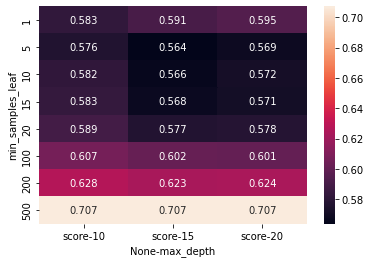

In [ ]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [ ]:
dt = DecisionTreeRegressor(max_depth=15, min_samples_leaf=10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=10)

In [ ]:
print(export_text(dt, feature_names=dv.get_feature_names()))

In [ ]:
y_pred = dt.predict(X_val)
score = rmse(y_val, y_pred)
score.round(3)

0.566

### RandomForest

In [ ]:
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#### Estimadores

In [ ]:
scores = []

for n in range(10, 201, 10):
    print(n)
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = rmse(y_val, y_pred)
    
    scores.append((n, score))

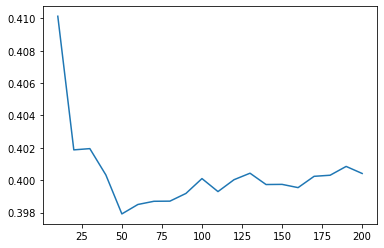

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])
plt.plot(df_scores.n_estimators, df_scores.score)

In [ ]:
score_model = 0.398
n_estimators = 50

#### Max Depth


In [ ]:
scores = []

for d in [5, 10, 15]:
    print('d', d)
    for n in range(10, 201, 10):
        print('n', n)
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = rmse(y_val, y_pred)

        scores.append((d, n, score))

In [ ]:
columns = ['max_depth', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

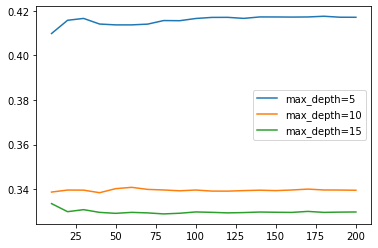

In [ ]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.score,
             label='max_depth=%d' % d)

plt.legend()

#### Leafs


In [ ]:
max_depth = 15
scores = []

for s in [1, 3, 5, 10, 50]:
    print('s',s)
    for n in range(10, 201, 10):
        print('n',n)
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = rmse(y_val, y_pred)

        scores.append((s, n, score))

In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

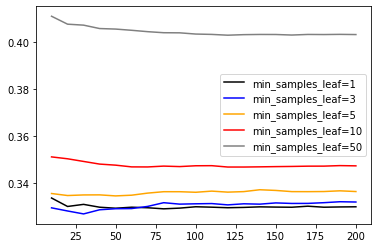

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.score,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [ ]:
min_samples_leaf = 1
rf = RandomForestRegressor(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, n_estimators=200, random_state=1)

In [ ]:
y_pred = rf.predict(X_val)
score = rmse(y_val, y_pred)
score

0.3297198896965495

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
scores = {}    

In [ ]:
#@ DEFINING THE FUNCTION:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
%%capture output
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)
scores['eta=0.3'] = parse_xgb_output(output)


In [ ]:
y_pred = model.predict(dval)
score = rmse(y_val, y_pred)
score

0.32327428

In [ ]:
%%capture output
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)
scores['eta=0.1'] = parse_xgb_output(output)

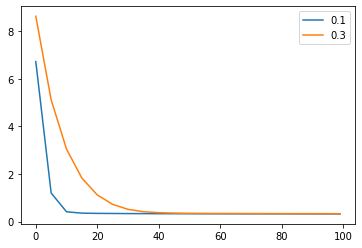

In [ ]:
#@ INSPECTION:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_rmse,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_rmse,
        label='0.3')
plt.legend()
plt.show()

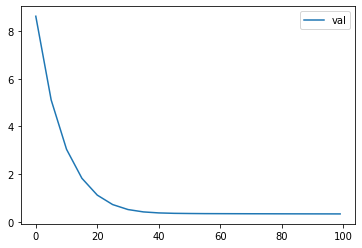

In [ ]:
df_score = parse_xgb_output(output)
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()

#### Parameter Tuning

##### ETA

In [ ]:
scores = {}

In [ ]:
%%capture output
# for eta in [0.01, 0.1, 0.3]:
eta = 0.3
xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                verbose_eval=5,
                evals=watchlist)
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [ ]:
scores.items()

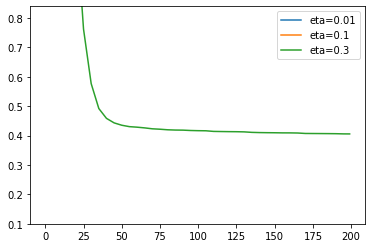

In [ ]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.ylim(0.1, 0.84)
plt.legend()

##### Max Depth

In [ ]:
scores = {}

In [ ]:
%%capture output
eta = 0.1
max_depth = 12
xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                verbose_eval=5,
                evals=watchlist)
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [ ]:
scores.items()

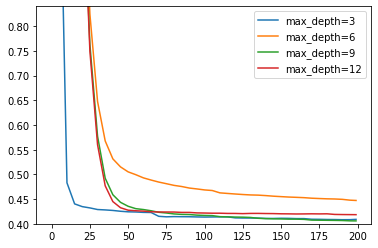

In [ ]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=max_depth)

plt.ylim(0.4, 0.84)
plt.legend()

#### Min child 

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 30,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

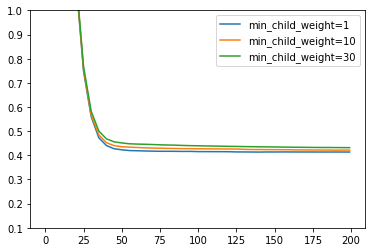

In [ ]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=min_child_weight)

plt.ylim(0.10, 1)
plt.legend()

In [ ]:
eta = 0.1
max_depth = 9
num_boost_round=200
min_child_weight=1

##### Subsample

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    'objective': 'reg:squarederror',
    'subsample': 0.30,

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'subsample=%s' % (xgb_params['subsample'])
scores[key] = parse_xgb_output(output)
key

'subsample=0.3'

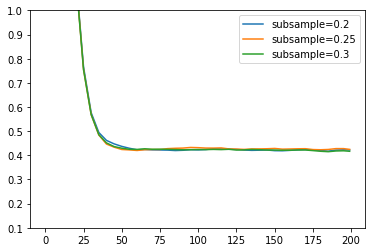

In [ ]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=min_child_weight)

plt.ylim(0.1, 1)
plt.legend()

##### Lambda

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    'objective': 'reg:squarederror',
    'lambda': 5,
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'lambda=%s' % (xgb_params['lambda'])
scores[key] = parse_xgb_output(output)
key

'lambda=5'

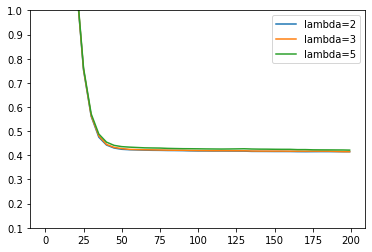

In [ ]:
for lambda_, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=lambda_)

plt.ylim(0.1, 1)
plt.legend()

### Final Model

In [ ]:
max_depth = 15
min_samples_leaf = 1
rf = RandomForestRegressor(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, n_estimators=200, random_state=1)

In [ ]:
y_pred = rf.predict(X_val)
score = rmse(y_val, y_pred)
score

0.4051077524980498

In [ ]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
2672,nivel_detallado=especializacion,0.207042
2096,financiamiento=ministerio de energia y recurso...,0.194266
2676,nivel_detallado=pregrado,0.109424
2076,destino=internacional,0.063401
2077,destino=nacional,0.062240
2695,pais_de_estudios=ecuador,0.056068
0,age,0.038511
2724,programa_general=programa de becas senescyt,0.031546
2669,nivel_detallado=capacitacion,0.018774
2093,financiamiento=ex ifth,0.016328


# Explicación


- Se tiene 97 datos faltantes de monto_contratado y se elimnan porque es la variable objetivo.
- Las becas que predominan son hacia a los de etnia mestiza y a personas de género femenino.
- Se elimina las columnas:
      -  id_unico: porque es una variable del registro.
      fecha_de_suscripcion
      fecha_inicio_financiamiento
        fecha_fin_financiamiento
fecha_inicio_estudios
fecha_inicio_estudios
estado_beca
estado_estudiante




- Fecha de nacimiento para determinar que edad es la que predomia.


# Temas Pendientes
- TODO: Agregar el conteo de los elements de las variables categóricas

# Temas a explicar
- Por qué eliminamos a los que no tienen montos registrados
- Como tratar con valores faltantes?
- Por qué hay tantos casos en Santa Elena.
- Distribución de la variable montos de realización.
- El estado de la beca diostribución, de los datos.
- Estado del estudiante durante la beca 
- Fechas  de nacimiento control para determinar las posibles fallas al determinar las fechas 
-  Fecha fin estudios para la beca cuanto recibe el usuario para dotar de lab eca.
- fecha_fin_financiamiento: revisar si los datos de la demanda de la beca genera correctamente las fechas de la beca para solicitarla.
- monto_contratado Monto contratado para la beca a solicitar.
- Porque renuncia a la beca el estudiante en escenario
- area_estudio_detallado qie items son los mas valorados a la hora de asignar becas al estudio.
- Porque una persona renuncia a la beca que se está asignadole
- Que se asigna a las diferntes áreas sobre las respectivas páreas de estudio.


# BIBLIOGRAFÍA
- https://docs.google.com/spreadsheets/d/169DArFYGjDyJ_izOQZhacD4G2gfAcp0g/edit#gid=1150139697
- https://docs.google.com/spreadsheets/d/1EalAb09g4yVKtl_jiQiJ8Z6pQ1HF9Eyx/edit#gid=1197338577
- https://www.datosabiertos.gob.ec/dataset/becas
